<a href="https://colab.research.google.com/github/saransh2320/Quora-Insincere-Questions-Classification/blob/master/Minor2_Quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Quora Insincere Question Classification**

In [ ]:
import os

**Downloading the required packages , files and datasets**

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# '/content/drive/My Drive/Kaggle API key/kaggle.json'
!cp '/content/drive/My Drive/Kaggle API key/kaggle.json' ~/.kaggle/

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=55ff775bb1b9159130894b6cd3471170ec5b157eb4ef9b4fe0554a4bcd48e2c3
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [ ]:
!kaggle -v

Kaggle API 1.5.6


In [ ]:
!kaggle competitions download -c quora-insincere-questions-classification --force

100% 6.03G/6.03G [02:13<00:00, 38.7MB/s]
100% 6.03G/6.03G [02:13<00:00, 48.4MB/s]


In [ ]:
!unzip "/content/quora-insincere-questions-classification.zip"

Archive:  /content/quora-insincere-questions-classification.zip
  inflating: embeddings.zip          
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!rm -rf "/content/embeddings.zip"

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-05-15 09:26:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-15 09:26:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-15 09:26:30--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


**Data Preprocessing and Visualization**

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import math

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [ ]:

embeddings_index = {}
f = open('/content/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
#print(embeddings_index.shape)

400000it [00:27, 14350.25it/s]

Found 400000 word vectors.


In [ ]:
train_df = pd.read_csv("/content/train.csv")
train_df, val_df = train_test_split(train_df, test_size=0.15)
train_df.head()

,qid,question_text,target
794751,9bbcb8e31575416b84c6,Why do black people often seem so much more co...,1
1259507,f6d32f30e870fa816d94,How can I transfer files to my SD card on Andr...,0
185566,244b46d72f902e54a219,How is it looks like when there is a cooperati...,0
778469,987e74c4734483777a63,"Really, does gingers have a soul?",1
1050905,cdeda2e0f79406f9cb81,What culture shocks did you encounter when mov...,0


In [ ]:
test_df, val_df = train_test_split(val_df, test_size = 0.1)
print(test_df.shape)
print(val_df.shape)
print(train_df.shape)

(176327, 3)
(19592, 3)
(1110203, 3)


In [ ]:

test_y = test_df['target']
test_x = test_df.drop(labels='target',axis=1)


In [ ]:
print(test_y.shape)
test_x.shape

(176327,)


(176327, 2)

In [ ]:
 train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110203 entries, 794751 to 564578
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1110203 non-null  object
 1   question_text  1110203 non-null  object
 2   target         1110203 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 33.9+ MB


In [ ]:
#test_df, val_df = train_test_split(val_df, test_size=0.5)


In [ ]:
counts = train_df['target'].value_counts()

In [ ]:
m = counts.iloc[0]
n = counts.iloc[1]
a0 = m/(m+n)
a1 = n/(m+n)
print("Total Questions", m+n)
print("Percentage of right question",a0*100)
print("Percentage of wrong question",a1*100)


Total Questions 1110203
Percentage of right question 93.81338367848042
Percentage of wrong question 6.186616321519578


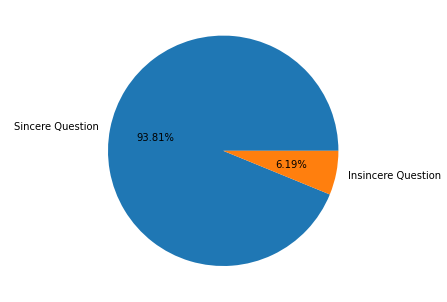

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['Sincere Question', 'Insincere Question']
students = [a0,a1]
ax.pie(students, labels = langs,autopct='%1.2f%%')
plt.show()

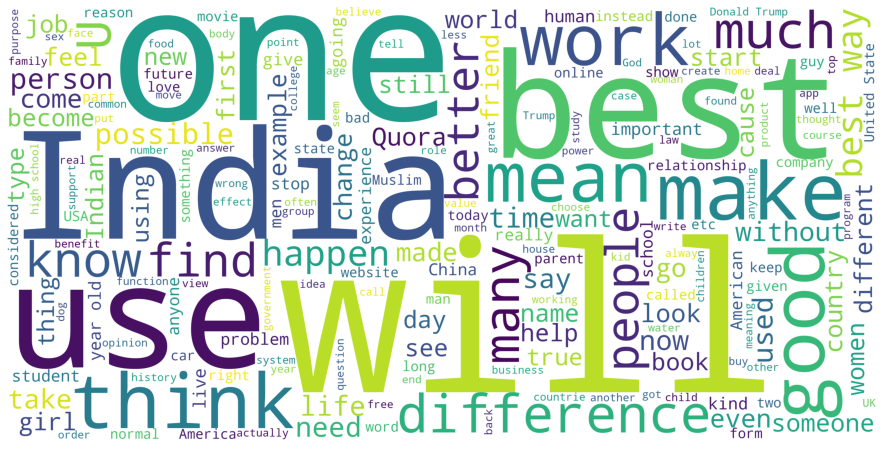

In [ ]:
from matplotlib import pyplot as plt

from wordcloud import WordCloud, STOPWORDS
data = pd.read_csv("/content/train.csv")
# data = data['question_text'].astype('str')
corpus = ' '.join(data['question_text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

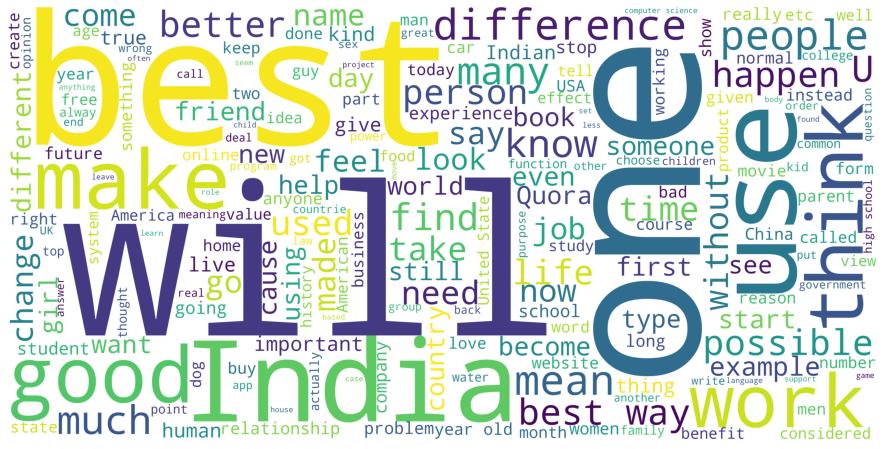

In [ ]:
sinceredata = data[data['target'] == 0]
sincerecorpus = ' '.join(sinceredata['question_text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(sincerecorpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

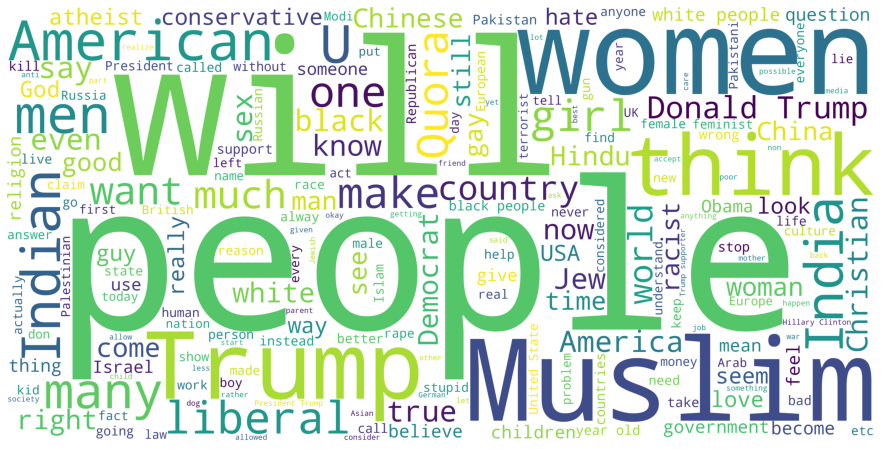

In [ ]:
insinceredata = data[data['target'] == 1]
insincerecorpus = ' '.join(insinceredata['question_text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(insincerecorpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

**Logistic Regression**

In [ ]:
import string
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,precision_score,recall_score

In [ ]:
# train = pd.read_csv("/content/train.csv").fillna(' ')
trainX = train_df['question_text'].values
trainY = train_df['target'].values

In [ ]:
# trainX,testX,trainY,testY =  train_test_split(trainX,trainY, test_size=0.2)
testX = test_df['question_text'].values
testY = test_df['target'].values
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1110203,)
(1110203,)
(176327,)
(176327,)


In [ ]:
alldata = np.concatenate((trainX,testX))
print(alldata.shape)

(1286530,)


In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=8000)
alldata_features = word_vectorizer.fit(alldata)

In [ ]:
trainX_features = alldata_features.transform(trainX)
testX_features = alldata_features.transform(testX)

In [ ]:
logisticReg = LogisticRegression(penalty='l2',max_iter=1000)
model = logisticReg.fit(trainX_features,trainY)

In [ ]:
y_predictions = logisticReg.predict(testX_features)

In [ ]:
confusion_matrix(testY, y_predictions)

array([[163442,   1937],
       [  6754,   4194]])

In [ ]:
lrf1 = f1_score(testY,y_predictions,average='binary')
lrp = precision_score(testY,y_predictions,average='binary')
lrr = recall_score(testY,y_predictions,average='binary')
print("Precision for Logistic Regression " , lrp)
print("Recall for Logistic Regression " , lrr)
print("F1 score for Logistic Regression " , lrf1)

Precision for Logistic Regression  0.6840645897895938
Recall for Logistic Regression  0.38308366824990864
F1 score for Logistic Regression  0.49112945722817497


**Bidirectional Recurrent Neural Network**

In [ ]:
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import  Dense, Bidirectional,SimpleRNN,Dropout

In [ ]:
def text_to_array(text):
    empyt_emb = np.zeros(300)
    text = text[:-1].split()[:30]
    embeds = [embeddings_index.get(x, empyt_emb) for x in text]
    embeds+= [empyt_emb] * (30 - len(embeds))
    return np.array(embeds)

# train_vects = [text_to_array(X_text) for X_text in tqdm(train_df["question_text"])]
val_vects = np.array([text_to_array(X_text) for X_text in tqdm(val_df["question_text"])])
val_y = np.array(val_df["target"])

100%|██████████| 19592/19592 [00:01<00:00, 17771.55it/s]


Batch function

In [ ]:
batch_size = 128

def batch_gen(train_df):
    n_batches = math.ceil(len(train_df) / batch_size)
    while True: 
        train_df = train_df.sample(frac=1.)  # Shuffle the data.
        for i in range(n_batches):
            texts = train_df.iloc[i*batch_size:(i+1)*batch_size, 1]
            text_arr = np.array([text_to_array(text) for text in texts])
            yield text_arr, np.array(train_df["target"][i*batch_size:(i+1)*batch_size])

In [ ]:
model = Sequential()
model.add(Bidirectional(SimpleRNN(16, return_sequences=True),
                        input_shape=(30, 300)))
model.add(Bidirectional(SimpleRNN(16)))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
# metrics=[get_f1]
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 30, 32)            10144     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 11,745
Trainable params: 11,745
Non-trainable params: 0
_________________________________________________________________


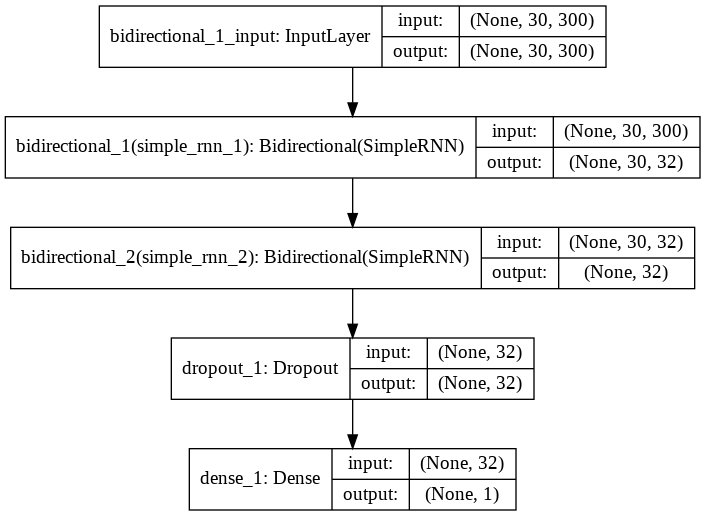

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
mg = batch_gen(train_df)

In [ ]:
model_histroy = model.fit_generator(mg, epochs=10,
                    steps_per_epoch=512,
                    validation_data=(val_vects, val_y),
                    verbose=True)

Epoch 1/10
512/512 [==============================] - 46s 89ms/step - loss: 0.2006 - accuracy: 0.9343 - val_loss: 0.1706 - val_accuracy: 0.9383
Epoch 2/10
512/512 [==============================] - 44s 85ms/step - loss: 0.1687 - accuracy: 0.9397 - val_loss: 0.1660 - val_accuracy: 0.9396
Epoch 3/10
512/512 [==============================] - 44s 86ms/step - loss: 0.1600 - accuracy: 0.9422 - val_loss: 0.1607 - val_accuracy: 0.9397
Epoch 4/10
512/512 [==============================] - 44s 86ms/step - loss: 0.1598 - accuracy: 0.9418 - val_loss: 0.1575 - val_accuracy: 0.9404
Epoch 5/10
512/512 [==============================] - 44s 85ms/step - loss: 0.1582 - accuracy: 0.9422 - val_loss: 0.1613 - val_accuracy: 0.9409
Epoch 6/10
512/512 [==============================] - 44s 86ms/step - loss: 0.1559 - accuracy: 0.9430 - val_loss: 0.1554 - val_accuracy: 0.9410
Epoch 7/10
512/512 [==============================] - 44s 85ms/step - loss: 0.1534 - accuracy: 0.9437 - val_loss: 0.1552 - val_accuracy:

In [ ]:
from matplotlib import pyplot as plt


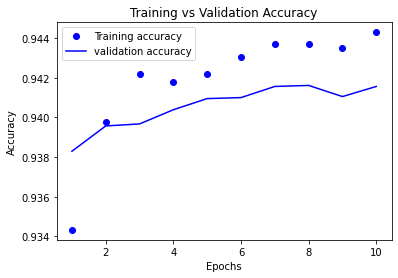

In [ ]:
accuracy = model_histroy.history['accuracy']
val_accuracy = model_histroy.history['val_accuracy']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label = 'Training accuracy')
plt.plot(epochs,val_accuracy,'b',label = 'validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
batch_size = 256
def batch_gen_test_y(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        #texts = test_df.iloc[i*batch_size:(i+1)*batch_size, 1]
        #text_arr = np.array([text_to_array(text) for text in texts])
        yield np.array(test_df["target"][i*batch_size:(i+1)*batch_size])



In [ ]:
test_y = np.array(test_y)
print(type(test_y))

<class 'numpy.ndarray'>


In [ ]:
batch_size = 256
def batch_gen_test(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        texts = test_df.iloc[i*batch_size:(i+1)*batch_size, 1]
        text_arr = np.array([text_to_array(text) for text in texts])
        yield text_arr

#test_df = pd.read_csv("/content/test.csv")

all_preds = []
for x in tqdm(batch_gen_test(test_df)):
    all_preds.extend(model.predict_classes(x).flatten())


689it [00:58, 11.69it/s]


In [ ]:
all_preds = np.array(all_preds)

In [ ]:
gru_result = np.copy(all_preds)

In [ ]:
confusion_matrix(test_y, all_preds)

array([[163113,   2141],
       [  7684,   3389]])

In [ ]:
f1 = f1_score(test_y,all_preds)
recall = recall_score(test_y,all_preds)
precision = precision_score(test_y,all_preds)
print("Precision for Bidirectional RNN " , precision)
print("Recall for Bidirectional RNN " , recall)
print("F1 score for Bidirectional RNN " , f1)

Precision for Bidirectional RNN  0.6128390596745027
Recall for Bidirectional RNN  0.30605978506276527
F1 score for Bidirectional RNN  0.408239474793712


In [ ]:
import h5py

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


Gated recurrent units (GRUs)

In [ ]:
from keras.models import Sequential
from keras.layers import CuDNNGRU,GRU
from keras.layers import  Dense, Bidirectional

In [ ]:
model_gru = Sequential()
model_gru.add(Bidirectional(GRU(16,return_sequences=True),input_shape = (30,300)))
model_gru.add(Bidirectional(GRU(2)))
model_gru.add(Dense(1,activation = "sigmoid"))

model_gru.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [ ]:
mg_for_gru = batch_gen(train_df)

In [ ]:
model_gru_history =  model_gru.fit_generator(mg_for_gru, epochs=10,
                    steps_per_epoch=512,
                    validation_data=(val_vects, val_y),
                    verbose=True)

Epoch 1/10
512/512 [==============================] - 219s 428ms/step - loss: 0.2218 - accuracy: 0.9300 - val_loss: 0.1672 - val_accuracy: 0.9385
Epoch 2/10
512/512 [==============================] - 214s 417ms/step - loss: 0.1569 - accuracy: 0.9439 - val_loss: 0.1531 - val_accuracy: 0.9443
Epoch 3/10
512/512 [==============================] - 213s 416ms/step - loss: 0.1460 - accuracy: 0.9457 - val_loss: 0.1457 - val_accuracy: 0.9457
Epoch 4/10
512/512 [==============================] - 211s 413ms/step - loss: 0.1470 - accuracy: 0.9456 - val_loss: 0.1424 - val_accuracy: 0.9464
Epoch 5/10
512/512 [==============================] - 212s 414ms/step - loss: 0.1416 - accuracy: 0.9472 - val_loss: 0.1406 - val_accuracy: 0.9464
Epoch 6/10
512/512 [==============================] - 212s 415ms/step - loss: 0.1387 - accuracy: 0.9476 - val_loss: 0.1397 - val_accuracy: 0.9474
Epoch 7/10
512/512 [==============================] - 212s 414ms/step - loss: 0.1396 - accuracy: 0.9479 - val_loss: 0.1368 -

In [ ]:
batch_size = 256
def batch_gen_test(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        texts = test_df.iloc[i*batch_size:(i+1)*batch_size, 1]
        text_arr = np.array([text_to_array(text) for text in texts])
        yield text_arr

#test_df = pd.read_csv("/content/test.csv")

all_preds = []
for x in tqdm(batch_gen_test(test_df)):
    all_preds.extend(model_gru.predict_classes(x).flatten())


689it [02:43,  4.21it/s]


In [ ]:
all_preds = np.array(all_preds)

In [ ]:
confusion_matrix(test_y, all_preds)

array([[162814,   2682],
       [  6274,   4557]])

In [ ]:
f1 = f1_score(test_y,all_preds)
recall = recall_score(test_y,all_preds)
precision = precision_score(test_y,all_preds)
print("Precision for Bidirectional GRU " , precision)
print("Recall for Bidirectional GRU " , recall)
print("F1 score for Bidirectional GRU " , f1)

Precision for Bidirectional GRU  0.6295068379610443
Recall for Bidirectional GRU  0.420736774074416
F1 score for Bidirectional GRU  0.5043718871057


In [ ]:
import h5py

In [ ]:
model_gru_json = model_gru.to_json()
with open("model_gru.json", "w") as json_file:
    json_file.write(model_gru_json)
# serialize weights to HDF5
model_gru.save_weights("model_gru.h5")
print("Saved model to disk")

Saved model to disk


LSTM Implementation

In [ ]:
from keras.models import Sequential
from keras.layers import CuDNNLSTM,LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(16, return_sequences=True),input_shape=(30, 300)))
model_lstm.add(Bidirectional(LSTM(2)))
model_lstm.add(Dense(1, activation="sigmoid"))

model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
mg_for_lstm = batch_gen(train_df)

In [ ]:
model_lstm_history =  model_lstm.fit_generator(mg_for_lstm, epochs=10,
                    steps_per_epoch=512,
                    validation_data=(val_vects, val_y),
                    verbose=True)

Epoch 1/10
512/512 [==============================] - 178s 347ms/step - loss: 0.2129 - accuracy: 0.9375 - val_loss: 0.1638 - val_accuracy: 0.9434
Epoch 2/10
512/512 [==============================] - 175s 341ms/step - loss: 0.1569 - accuracy: 0.9443 - val_loss: 0.1490 - val_accuracy: 0.9461
Epoch 3/10
512/512 [==============================] - 174s 340ms/step - loss: 0.1483 - accuracy: 0.9456 - val_loss: 0.1427 - val_accuracy: 0.9471
Epoch 4/10
512/512 [==============================] - 174s 339ms/step - loss: 0.1476 - accuracy: 0.9450 - val_loss: 0.1425 - val_accuracy: 0.9468
Epoch 5/10
512/512 [==============================] - 173s 338ms/step - loss: 0.1454 - accuracy: 0.9455 - val_loss: 0.1370 - val_accuracy: 0.9491
Epoch 6/10
512/512 [==============================] - 173s 338ms/step - loss: 0.1400 - accuracy: 0.9476 - val_loss: 0.1367 - val_accuracy: 0.9491
Epoch 7/10
512/512 [==============================] - 172s 336ms/step - loss: 0.1389 - accuracy: 0.9482 - val_loss: 0.1360 -

In [ ]:
batch_size = 256
def batch_gen_test(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        texts = test_df.iloc[i*batch_size:(i+1)*batch_size, 1]
        text_arr = np.array([text_to_array(text) for text in texts])
        yield text_arr

#test_df = pd.read_csv("/content/test.csv")

all_preds = []
for x in tqdm(batch_gen_test(test_df)):
    all_preds.extend(model_lstm.predict_classes(x).flatten())



0it [00:00, ?it/s]
1it [00:00,  2.15it/s]
2it [00:00,  2.68it/s]
3it [00:00,  3.24it/s]
4it [00:00,  3.78it/s]
5it [00:01,  4.33it/s]
6it [00:01,  4.82it/s]
7it [00:01,  5.23it/s]
8it [00:01,  5.59it/s]
9it [00:01,  5.82it/s]
10it [00:01,  6.03it/s]
11it [00:02,  6.12it/s]
12it [00:02,  6.12it/s]
13it [00:02,  5.98it/s]
14it [00:02,  6.19it/s]
15it [00:02,  6.38it/s]
16it [00:02,  6.32it/s]
17it [00:02,  6.14it/s]
18it [00:03,  6.26it/s]
19it [00:03,  6.37it/s]
20it [00:03,  6.51it/s]
21it [00:03,  6.61it/s]
22it [00:03,  6.43it/s]
23it [00:03,  6.50it/s]
24it [00:04,  6.47it/s]
25it [00:04,  6.52it/s]
26it [00:04,  6.41it/s]
27it [00:04,  6.52it/s]
28it [00:04,  6.56it/s]
29it [00:04,  6.54it/s]
30it [00:04,  6.63it/s]
31it [00:05,  6.58it/s]
32it [00:05,  6.53it/s]
33it [00:05,  6.61it/s]
34it [00:05,  6.68it/s]
35it [00:05,  6.63it/s]
36it [00:05,  6.69it/s]
37it [00:06,  6.67it/s]
38it [00:06,  6.73it/s]
39it [00:06,  6.69it/s]
40it [00:06,  6.75it/s]
41it [00:06,  6.74it/s]
42it 

In [ ]:
all_preds = np.array(all_preds)

In [ ]:
confusion_matrix(test_y, all_preds)

array([[162503,   2751],
       [  5805,   5268]])

In [ ]:
f1 = f1_score(test_y,all_preds)
recall = recall_score(test_y,all_preds)
precision = precision_score(test_y,all_preds)
print("Precision for Bidirectional GRU " , precision)
print("Recall for Bidirectional GRU " , recall)
print("F1 score for Bidirectional GRU " , f1)

Precision for Bidirectional GRU  0.5671963095848283
Recall for Bidirectional GRU  0.5046976192647998
F1 score for Bidirectional GRU  0.5341249155323873


In [ ]:
import h5py

2.10.0


In [ ]:
model_lstm_json = model_lstm.to_json()
with open("model_lstm.json", "w") as json_file:
    json_file.write(model_lstm_json)
# serialize weights to HDF5
model_lstm.save_weights("model_lstm.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from google.colab import files
files.upload()

Saving model_lstm.json to model_lstm.json


{'model_lstm.json': b'{"class_name": "Sequential", "config": {"name": "sequential_3", "layers": [{"class_name": "Bidirectional", "config": {"name": "bidirectional_3", "trainable": true, "batch_input_shape": [null, 30, 300], "dtype": "float32", "layer": {"class_name": "LSTM", "config": {"name": "lstm_3", "trainable": true, "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 16, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": nu

**USER INTERACTION**

In [ ]:
from keras.models import load_model,model_from_json

In [ ]:
# load json and create model
lstm_json_file = open('/content/model_lstm.json', 'r')
lstm_loaded_model_json = lstm_json_file.read()
lstm_json_file.close()
lstm_loaded_model = model_from_json(lstm_loaded_model_json)

# load weights into new model
lstm_loaded_model.load_weights("/content/model_lstm.h5")
# print("Loaded model from disk")

# loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# score = loaded_model.evaluate(X_test, Y_test, verbose=0)
# print ("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
rnn_json_file = open('/content/model.json','r')
rnn_loaded_model_json = rnn_json_file.read()
rnn_json_file.close()
rnn_loaded_model = model_from_json(rnn_loaded_model_json)

rnn_loaded_model.load_weights("/content/model.h5")

In [ ]:
gru_json_file = open('/content/model_gru.json','r')
gru_loaded_model_json = gru_json_file.read()
gru_json_file.close()
gru_loaded_model = model_from_json(gru_loaded_model_json)

gru_loaded_model.load_weights("/content/model_gru.h5")

In [ ]:
def predictit(textarry):
  result1 = rnn_loaded_model.predict(textarry)[0]
  result2 = gru_loaded_model.predict(textarry)[0]
  result3 = lstm_loaded_model.predict(textarry)[0]
  # print(result1,result2,result3)
  result1 = 1 if result1>=0.5 else 0
  result2 = 1 if result2>=0.5 else 0
  result3 = 1 if result3>=0.5 else 0
  if(result1 + result2 + result3 >= 2):
    return 1
  else:
    return 0


In [ ]:
while(True):
  user_input = input("Enter the question : ")
  user_question = np.array([user_input])
  textarry = []
  textarry = np.array([text_to_array(text) for text in user_question])
  results = predictit(textarry)
  if(results == 1):
    print("INSINCERE/WRONG QUESTION")
  else:
    print("SINCERE/RIGHT QUESTION")

Enter the question : How to play cricket?
SINCERE/RIGHT QUESTION
Enter the question : Why are thin people better than fat people?
INSINCERE/WRONG QUESTION
Enter the question : when will Donald Trump Die?
SINCERE/RIGHT QUESTION
Enter the question : Is hate only solution for black people?
INSINCERE/WRONG QUESTION
Enter the question : Why we should not like hindu people?
SINCERE/RIGHT QUESTION
Enter the question : how to kill donald trump?
SINCERE/RIGHT QUESTION
Enter the question : How to deal with feminist?
SINCERE/RIGHT QUESTION
Enter the question : which religion is best?
SINCERE/RIGHT QUESTION
Enter the question : Poor people are always jealous of rich, why?
SINCERE/RIGHT QUESTION
Enter the question : What north indian think about south indian culture ?
SINCERE/RIGHT QUESTION


KeyboardInterrupt: ignored

TypeError: ignored